# Sagemaker Sydney Summit 2019 Reinforcement Learning Lab

Authors: Paul Conyngham & William Xu | StarAi Project - Machine Learning Engineers - | Email : contact@starai.com

---

![alt text](https://cdn-images-1.medium.com/max/1200/1*XyIpmXXAjbXerDzmGQL1yA.gif)

.

Hi! and welcome to the sage maker Reinforcement Learning lab for AWS Summit 2019. 

This workshop gives you an introduction to state of the art Reinforcement Learning & shows you how, using AWS, you can parallelise the training of your reinforcement learning algorithms to get insanely fast turn around times & results for your reinforcement learning experiments.

Reinforcement Learning has been directly responsible for some of the biggest breakthoughs in the field of modern machine learning. 



Some of the events you may have heard about in the media include [AlphaGo](https://deepmind.com/research/alphago/), [OpenAI Five](https://openai.com/blog/openai-five/) &[ Deepmind's AlphaStar](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/) - all powered by Reinforcement Learning.

Outside of games however, we are beginning to see more use cases of Reinforcement Learning in the wild. 

Including [web stores product recommendations](https://arxiv.org/pdf/1805.02343.pdf),  [  news recommendation](https://towardsdatascience.com/deep-reinforcement-learning-for-news-recommendation-part-1-architecture-5741b1a6ed56), [in the finance industry](https://www.forbes.com/sites/quora/2018/07/25/what-are-the-latest-works-on-reinforcement-learning-in-the-financial-field/#3c35b15b44df) , [Automated Architecture search for Machine Learning using RL](https://ai.googleblog.com/2017/05/using-machine-learning-to-explore.html) ,[End to End  Machine Learning for Self Driving Cars](https://wayve.ai/), and last and most excitingly the field of Robotics where [Deep Reinforcement Learning is exploding!](https://www.therobotreport.com/reinforcement-learning-industrial-robotics/)

But first, an intro to Jupyter notebooks! 

---


**For those new to Jupyter Notebooks** - the interface you are using right now - there are two types of "cell blocks" **text** (like the one you are reading) and **code blocks**.

To run code Cell blocks :

1.  First select the code cell by simply left clicking on it below, when you select it - it should get a green border as follows:

![alt text](https://i.ibb.co/rt9NdXL/Screen-Shot-2019-03-25-at-2-02-08-pm.png)

2.   Once the cell is selected, click the "run" button at the top of the notebook, which looks like this:

![alt text](https://i.ibb.co/fCwfvBk/Screen-Shot-2019-03-25-at-2-05-33-pm.png)

Hitting "shift-enter"together is also a shortcut for the Run command/button above


---



We want to get started with training as soon as possible, select the code cell directly below where is says "run the code cell below" and run it. If you need help follow step 1 & 2 above to do this


This will start our reinforcement learning model's training process. We will spend the rest of this lab explaining what is going on here line by line - with an amazing result to follow!

**run the code cell below:**

Once the cell block has run, continue scrolling & reading to continue the lesson

In [ ]:
# ONE CLICK REINFORCEMENT LEARNING!

# RUN ME BY FIRST SELECTING THIS BLOCK, AND CLICKING "RUN" ABOVE!
"""
### Import relevant libraries

First we imported the relevant Python libraries, you can re do this
"""
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML, Markdown
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from markdown_helper import generate_help_for_s3_endpoint_permissions, create_s3_endpoint_manually

gym_problem = 'breakout'



"""
### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket. 
S3 Buckets are a form of data storage available on AWS. 
Our bucket will be used for checkpointing and the metadata. 
"""
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))



"""
### Define Variables 

We define variables such as the job prefix for the training jobs 
and the image path for the container (only when this is BYOC).
"""
job_name_prefix = 'rl-gym-summit'
aws_region = boto3.Session().region_name

instance_type = "ml.p3.8xlarge"
train_instance_count = 1



"""
### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance 
`role = sagemaker.get_execution_role()` or, when running from local notebook instance, 
use utils method `role = get_execution_role()` to create an execution role.
"""
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))




"""
### Build docker container for SageMaker Training job.

The commented code below will build a container, 
however it takes some time so we've prebuilt the container for this workshop

    cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
    repository_short_name = "sagemaker-gym-ray-%s" % cpu_or_gpu
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)    
    print("the repo name is ", repository_short_name)
"""
custom_image_name = "413953306596.dkr.ecr.us-east-1.amazonaws.com/sagemaker-gym-ray-gpu"




"""
### Start a training job
This will run a training job on a a separate VM instance (ml.p3.8xlarge). 
You can view the status of this training job from the Amazon Sagemaker menu

Amazon Sagemaker --> Training --> Training Jobs
"""
metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)
    
estimator = RLEstimator(entry_point="train-%s.py" % gym_problem,
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=train_instance_count,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        hyperparameters={
                            # ml.p3.8xlarge has 32 cores. We have to leave 1 core for ray scheduler.
                            "rl.training.config.num_workers": 32 * train_instance_count - 1,
                            "rl.training.config.num_gpus": 2
                        }
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

### View Training Job
The above cell will run a training job on a a separate VM instance (ml.p3.8xlarge). You can view the status of this training job from the Amazon Sagemaker menu. It will take a few minutes for the instance to be created before training starts. 

If you like to see the above training job please follow this link

<a href="https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs" target="_blank">https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs</a>

# Explanation!

Today's current enthusiam around RL started only 4 years ago, with the release of [Deepmind DQN algorithm in the scientific journal nature in 2015.](https://www.nature.com/articles/nature14236)

For those who may not be aware, in the DQN paper, Deepmind took several classic atari 2600 games and learnt to play them at human level with just raw pixels values from the screen. 

When learning to play games, you & I as humans learnt to play this exact same way by just observing the raw images that are being produced by the screen!

But what really set DQN apart from previous work, was that in some instances, the DQN algorithm ***went beyond human level!***

Some of you may have seen this before, but in what has now become a famous example of Ai research work, let us watch DQN learning to play the Atari game of breakout at a super human level!

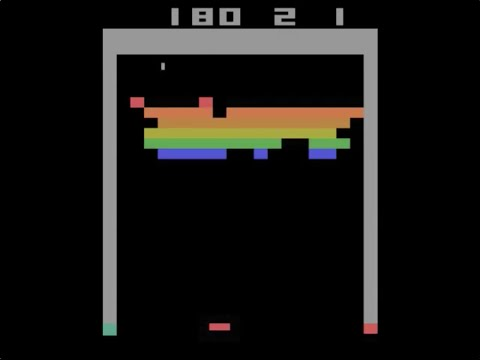

In [2]:
#If no video appears here - run this cell by selecting it and clicking the run button above or alternatively
# by pressing shift-enter

#title DQN Going Superhuman
#@markdown In this now classic video, watch & see how the DQN algorithm learns the absolute best way to play the Atari game of Breakout.
from IPython.display import YouTubeVideo 
YouTubeVideo('TmPfTpjtdgg', width=600, height=400)

.




Lets take a look at the DQN algorithm, training in 2015...

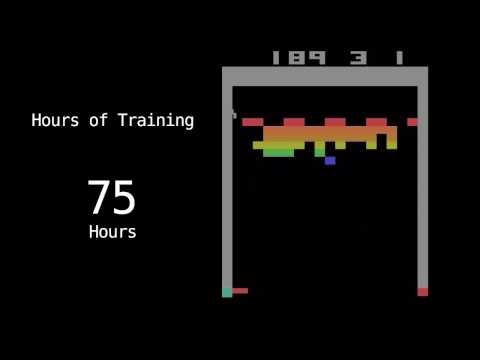

In [3]:
#If no video appears here - run this cell by selecting it and clicking the run button above or alternatively
# by pressing shift-enter


#@title DQN Training...
#@markdown Here we can see a DQN Agent training
from IPython.display import YouTubeVideo 
YouTubeVideo('eG1Ed8PTJ18', width=600, height=400)

One thing you might have noticed in the video above is "hours training". Unfortunately back in 2015, DQN took 75 hours to train a DQN up to human level.

**That is 3.125 days worth of compute time on a normal 2015 computer!**

Things have changed since 2015 however & lucky for us the introduction of DQN kicked off a wave of resurgence in academic study focussing on Reinforcement Learning, [leading to many new algorithms](https://arxiv.org/pdf/1708.07902.pdf), some of which we can see in the image below! 

**Notice how DQN is the middle!**

![alt text](https://i.ibb.co/sy9xRF2/Screen-Shot-2019-02-21-at-9-30-09-am.png)


.

In todays lab we are going to making use of an algorithm developed by Deepmind called "IMPALA" which is short hand for[ "Importance Weighted Actor-Learner Architectures"](https://arxiv.org/abs/1802.01561). IMPALA is a distant couzin of DQN and is state of the art being [actively used by Deepmind right now for their research. ](https://www.quora.com/Is-Deepmind-AIs-alphastar-a-model-free-or-model-based-RL-model)

Unlike DQN, IMPALA allows us to parallelize training of our Reinforcement Learning agents and makes use of both CPUs & GPUs.

## We are going to show you how, using AWS, you can parallelize the training of your reinforcment learning algorithms to get insanely fast turn around times & results for your reinforcement learning experiments.

The objective of today's lab is:

1. Make use of a state of the art Reinforcement Learning algorithm (IMPALA) to learn how to play the Atari game of breakout!
2. Make use of Amazon's state of the art compute resources. Instead of 3.125 days of training time, we are going to train our RL Agent to play Atari Breakout in 15 minutes.

.

---

**In the first cell block that you ran at the start of this workshop we actually started training out IMPALA algorithm on the Atari game of breakout!**

So you should be roughly 8 minutes though the training process already!

We are now going to walk through exactly what you did- so you can train your own experiments in the future!

But first lets see how our Reinforcement Learning agent doing!

### Visualizating our Reinforcement Learning Algorithm Playing!

While it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

In [ ]:
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

### Watch your Reinforcement Agent training live!!

Videos of certain rollouts get written to S3 during training.  We can observe our Reinforcement learning agent learning live!  Here we fetch the last 10 videos from S3, and render the last one.  

#### Initially you'll notice that the agent will lose the game straight away because it's not very intelligent yet, but if you continue to run the cell below every few minutes throughout the workshop you'll see the agent "learn" and get more intelligent over time.
&nbsp;
&nbsp;

In [ ]:
recent_videos = wait_for_s3_object(s3_bucket, intermediate_folder_key, tmp_dir, 
                                fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), limit=10)

last_video = recent_videos[-1]  # Pick which video to watch
os.system("sudo mkdir -p ./src/tmp_render/ && sudo cp {} ./src/tmp_render/last_video.mp4".format(last_video))
HTML('<video src="./src/tmp_render/last_video.mp4" controls autoplay></video>')

### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

#### Rerun the cell below every few minutes throughout the workshop to see the plot of the agent's "average reward" over time

In [ ]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
num_metrics = len(df)
if num_metrics == 0:
    print("No algorithm metrics found in CloudWatch")
else:
    plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
    plt.set_ylabel('Mean reward per episode')
    plt.set_xlabel('Training time (s)')

# End of lab.